In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, accuracy_score,
                           precision_score, recall_score, f1_score)
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import xgboost as xgb

import itertools

from scipy.stats import chi2_contingency
import warnings

from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
from scipy.stats import pearsonr, chi2_contingency, kruskal

import warnings



warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
df_test = pd.read_csv('base_telco.csv')


In [103]:
# Cambiar los nombres de las columnas a camelCase
def to_camel_case(s):
    parts = s.strip().replace('_', ' ').replace('-', ' ').split()
    return parts[0].lower() + ''.join(word.capitalize() for word in parts[1:])

df_test.columns = [to_camel_case(col) for col in df_test.columns]

df_test_copy = df_test.copy()

df_test_copy.columns

Index(['customerId', 'gender', 'age', 'married', 'numberOfDependents',
       'numberOfReferrals', 'tenureInMonths', 'offer', 'phoneService',
       'avgMonthlyLongDistanceCharges', 'multipleLines', 'internetService',
       'internetType', 'avgMonthlyGbDownload', 'onlineSecurity',
       'onlineBackup', 'deviceProtectionPlan', 'premiumTechSupport',
       'streamingTv', 'streamingMovies', 'streamingMusic', 'unlimitedData',
       'contract', 'paperlessBilling', 'paymentMethod', 'monthlyCharge',
       'totalCharges', 'totalRefunds', 'totalExtraDataCharges',
       'totalLongDistanceCharges', 'totalRevenue', 'customerStatus',
       'churnCategory', 'churnReason'],
      dtype='object')

In [ ]:
##'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['internetType']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['onlineBackup']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['onlineSecurity']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['deviceProtectionPlan']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['premiumTechSupport']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['streamingTv']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['streamingMovies']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['streamingMusic']] = 'NoInternetService'
df_test_copy.loc[df_test_copy['internetService'] == 'No',['unlimitedData']] = 'NoInternetService'

df_test_copy.loc[df_test_copy['internetService'] == 'No',['avgMonthlyGbDownload']] = 0

##phoneService
df_test_copy.loc[df_test_copy['phoneService'] == 'No',['avgMonthlyLongDistanceCharges']] = 0
df_test_copy.loc[df_test_copy['phoneService'] == 'No',['multipleLines']] = 'NoPhoneService'

##offer
df_test_copy.loc[df_test_copy['offer'].isna(), 'offer'] = 'NoOfferAccepted'

df_test_copy.loc[df_test_copy['customerStatus'] == 'Stayed', ['churnCategory']] = 'NoChurn'
df_test_copy.loc[df_test_copy['customerStatus'] == 'Stayed', ['churnReason']] = 'NoChurn'
df_test_copy.loc[df_test_copy['customerStatus'] == 'Joined', ['churnCategory']] = 'NoChurn'
df_test_copy.loc[df_test_copy['customerStatus'] == 'Joined', ['churnReason']] = 'NoChurn'

df_test_copy.loc[df_test_copy['internetService'] == 'No',['internetService',
       'internetType', 'avgMonthlyGbDownload', 'onlineSecurity',
       'onlineBackup', 'deviceProtectionPlan', 'premiumTechSupport',
       'streamingTv', 'streamingMovies', 'streamingMusic', 'unlimitedData',
       'contract', 'paperlessBilling', 'paymentMethod', 'monthlyCharge',
       'totalCharges', 'totalRefunds', 'totalExtraDataCharges',
       'totalLongDistanceCharges', 'totalRevenue', 'customerStatus',
       'churnCategory', 'churnReason']]

##no tiomar en cuenta el customerid
df_test_copy = df_test_copy.drop(columns=['customerId'])
                                                          


In [105]:
# Obtener nombres de columnas, tipos de dato y cantidad de datos vacíos, ordenado por datos faltantes
def resumen_columnas(df):
    resumen = pd.DataFrame({
        'Tipo de Dato': df.dtypes,
        'Datos Faltantes': df.isnull().sum(),
        'Porcentaje Faltantes': df.isnull().mean() * 100
    })
    resumen = resumen.sort_values(by='Datos Faltantes', ascending=False)
    return resumen

# Ejemplo de uso:
resumen_columnas(df_test_copy)
# Filtrar las columnas con datos faltantes
resumen = resumen_columnas(df_test_copy)
columnas_con_faltantes = resumen[resumen['Datos Faltantes'] > 0].index.tolist()

# Mostrar los valores únicos por cada columna con datos faltantes
for col in columnas_con_faltantes:
    print(f"\nColumna: {col}")
    print(df_test_copy[col].unique())



In [116]:
# Analizar columnas numéricas: contar negativos, calcular media, varianza, máximo y mínimo
df_test_copy['avgMonthlyLongDistanceCharges'] = pd.to_numeric(df_test_copy['avgMonthlyLongDistanceCharges'], errors='coerce')

# Identificar columnas numéricas y no numéricas, excluyendo 'customerId'
columnas_numericas = [col for col in df_test_copy.select_dtypes(include=['number']).columns if col.lower != 'customerId']
columnas_no_numericas = [col for col in df_test_copy.select_dtypes(exclude=['number']).columns if col != 'customerId']




resultados = []

for col in columnas_numericas:
    try:
        # Intentar convertir a numérico (forzar errores a NaN)
        serie = pd.to_numeric(df_test_copy[col], errors='coerce')
        negativos = (serie < 0).sum()
        media = serie.mean()
        varianza = serie.var()
        maximo = serie.max()
        minimo = serie.min()
        resultados.append({
            'Columna': col,
            'Negativos': negativos,
            'Media': round(media, 2) if pd.notnull(media) else None,
            'Varianza': round(varianza, 2) if pd.notnull(varianza) else None,
            'Máximo': maximo,
            'Mínimo': minimo
        })
    except Exception as e:
        print(f"Error procesando columna '{col}': {e}")
        resultados.append({
            'Columna': col,
            'Negativos': None,
            'Media': None,
            'Varianza': None,
            'Máximo': None,
            'Mínimo': None
        })

analisis_numerico = pd.DataFrame(resultados)

print("Resumen de análisis numérico:")
analisis_numerico



Resumen de análisis numérico:


,Columna,Negativos,Media,Varianza,Máximo,Mínimo
0,age,0,46.51,280.57,80.00,19.00
1,numberOfDependents,0,0.47,0.93,9.00,0.00
2,numberOfReferrals,0,1.95,9.01,11.00,0.00
3,tenureInMonths,0,32.39,602.31,72.00,1.00
4,avgMonthlyLongDistanceCharges,0,22.96,238.64,49.99,0.00
5,avgMonthlyGbDownload,0,20.52,416.93,85.00,0.00
6,monthlyCharge,120,63.60,973.74,118.75,-10.00
7,totalCharges,0,2280.38,5135755.18,8684.80,18.80
8,totalRefunds,0,1.96,62.45,49.79,0.00
9,totalExtraDataCharges,0,6.86,630.26,150.00,0.00


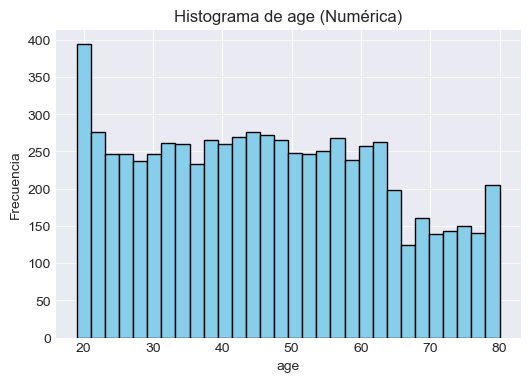

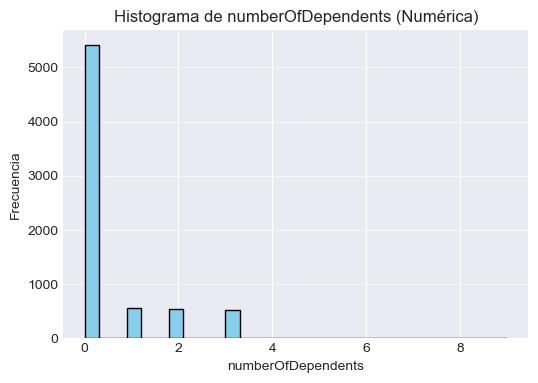

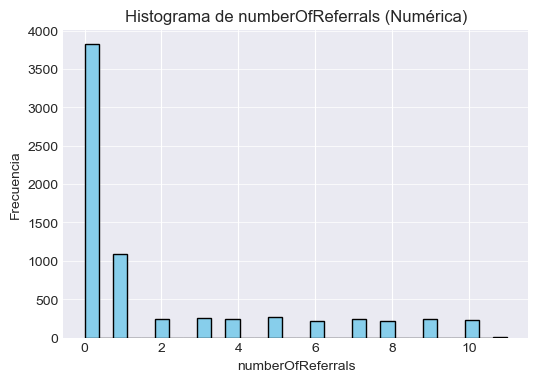

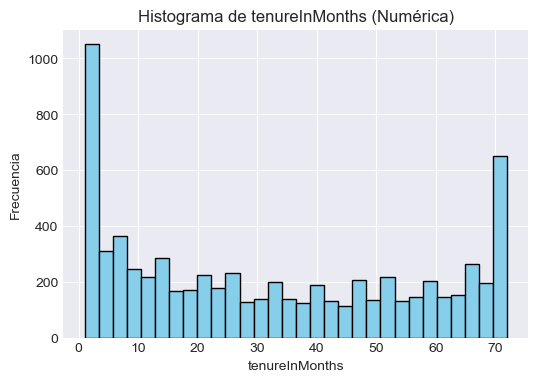

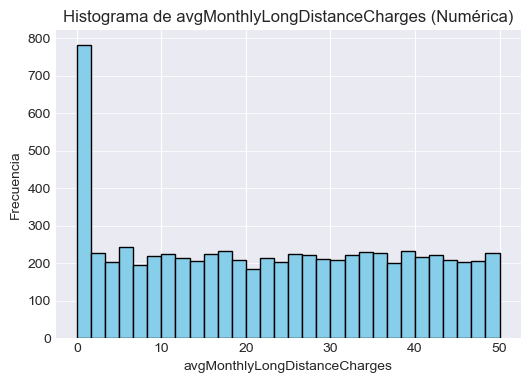

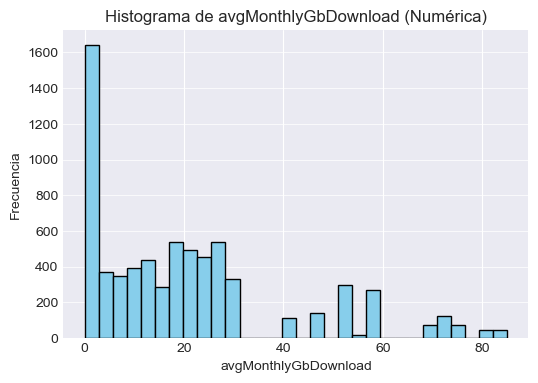

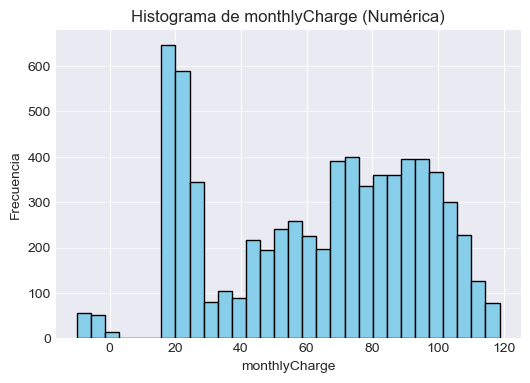

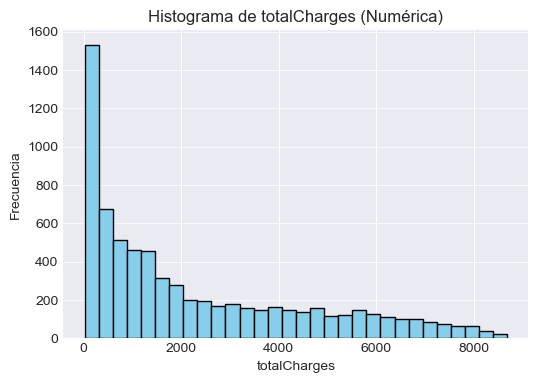

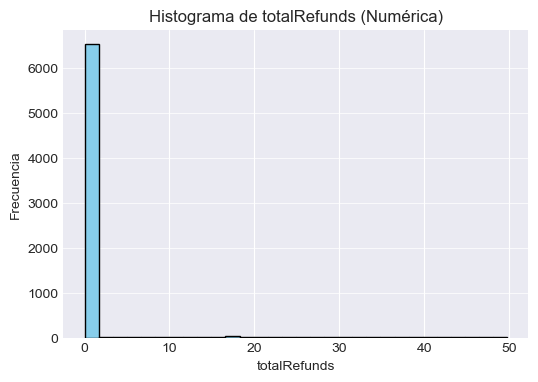

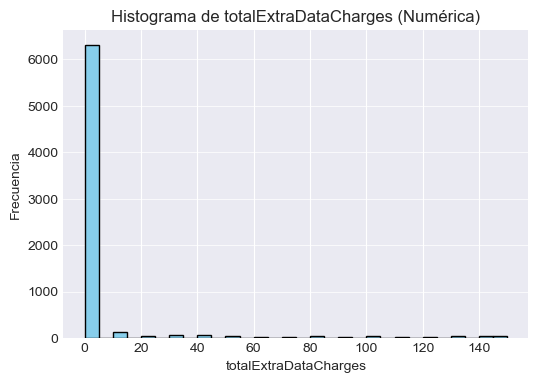

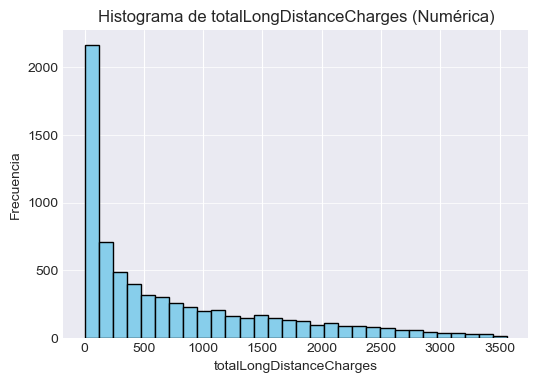

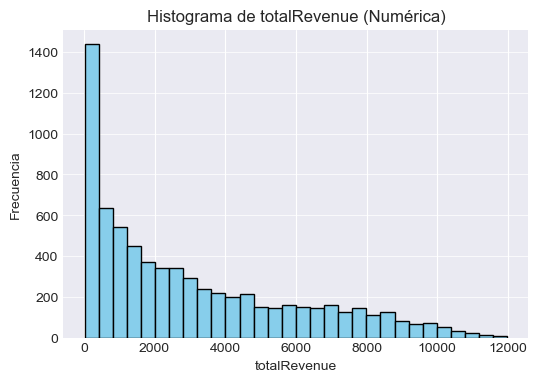

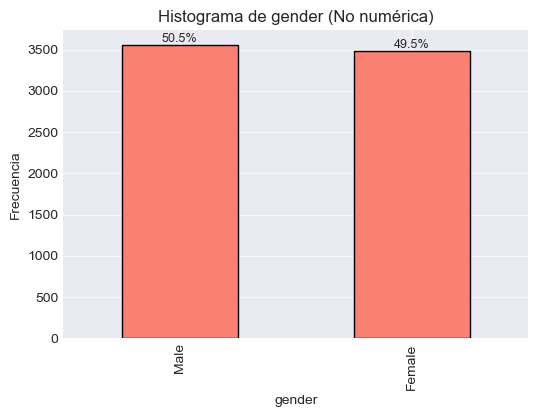

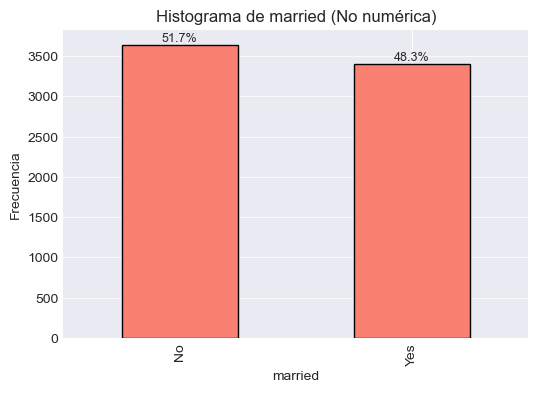

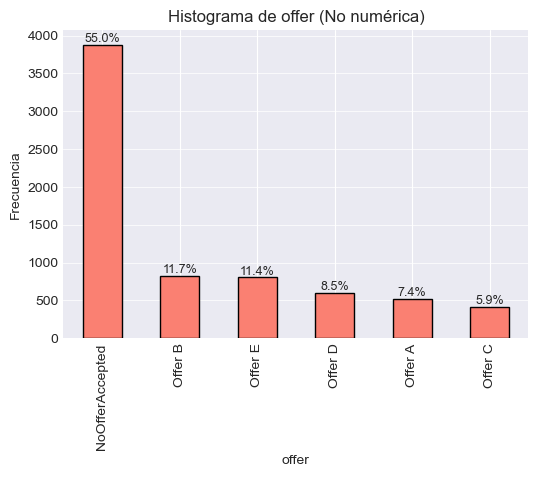

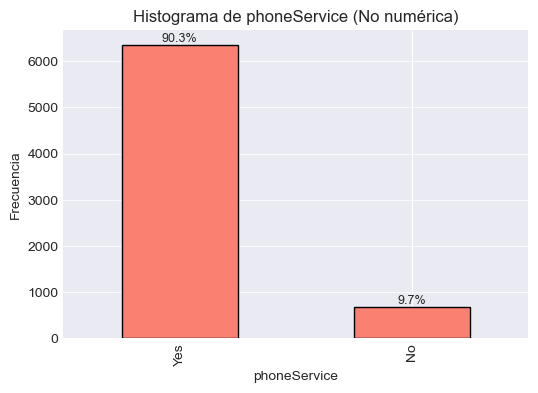

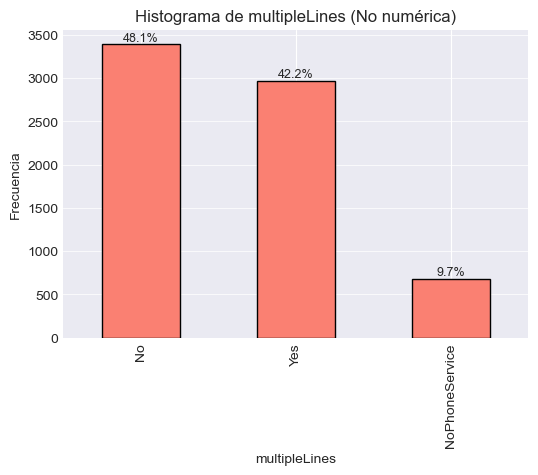

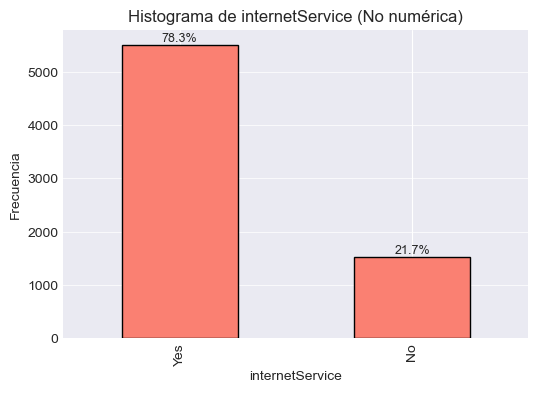

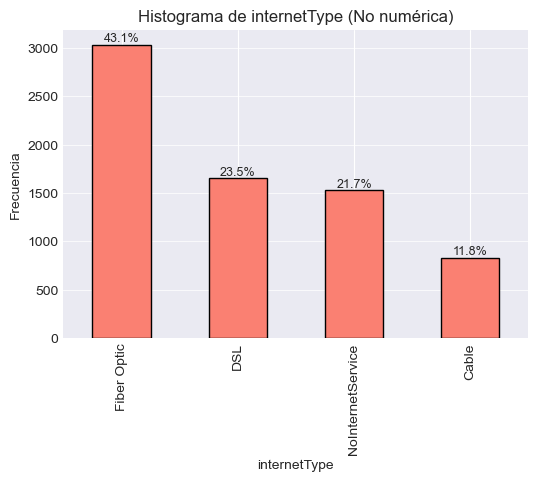

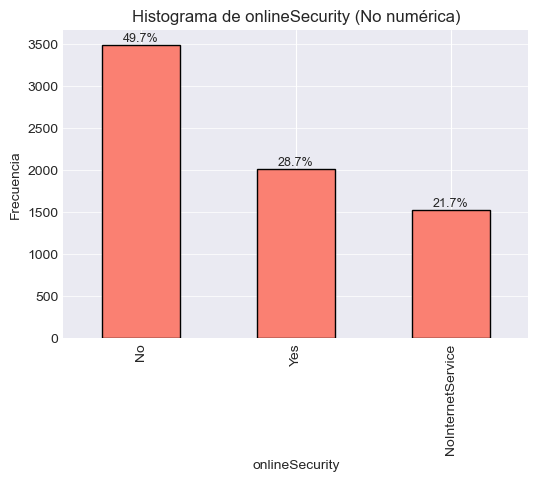

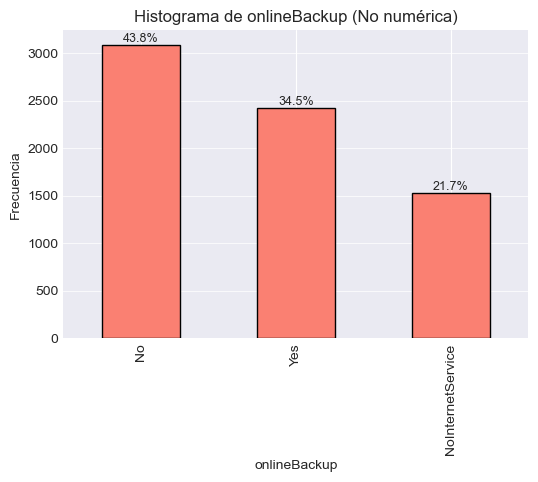

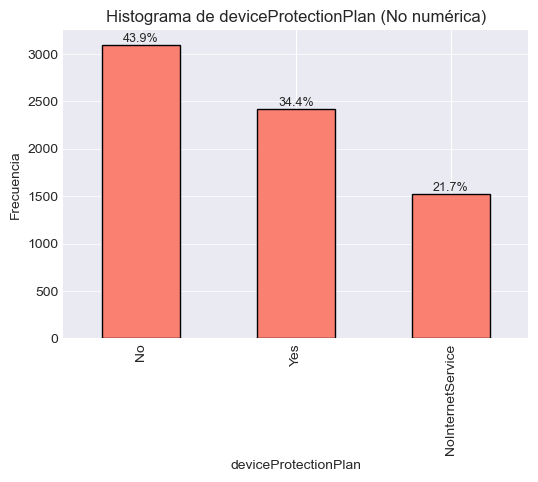

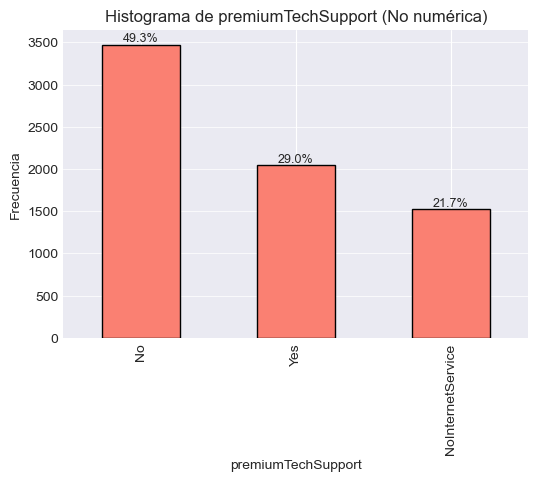

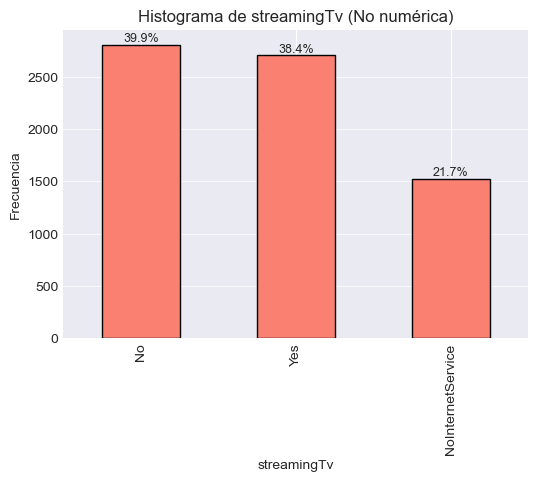

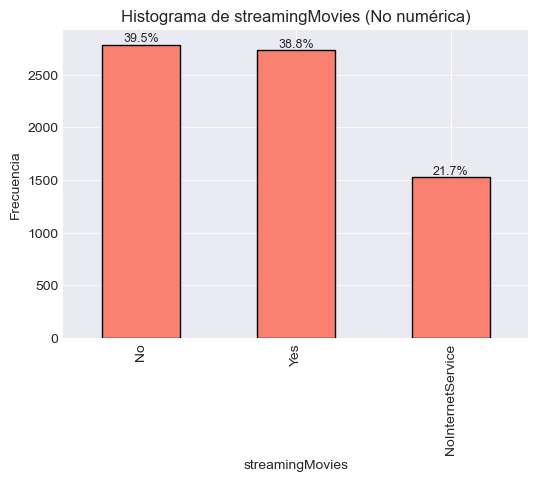

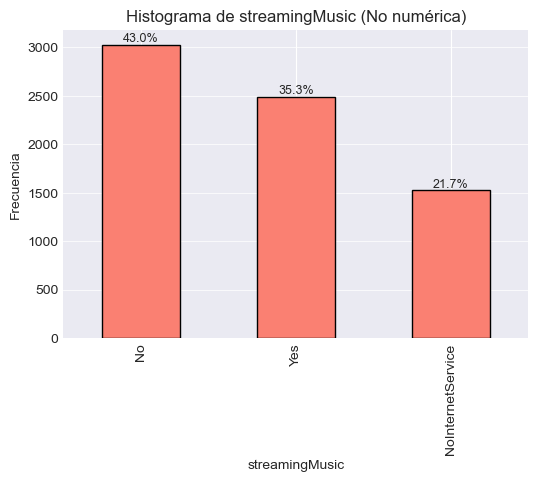

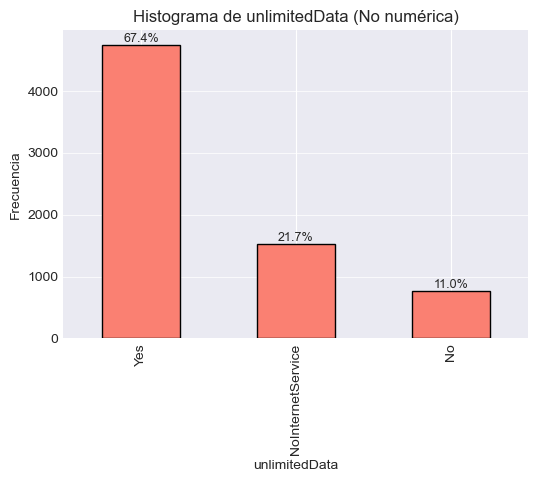

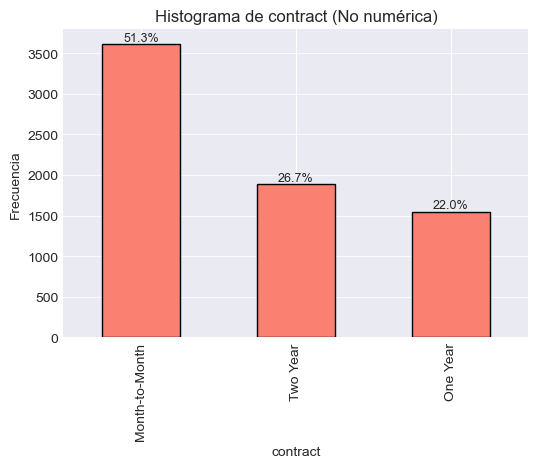

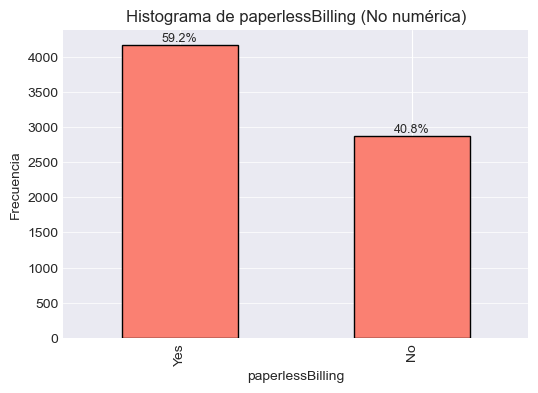

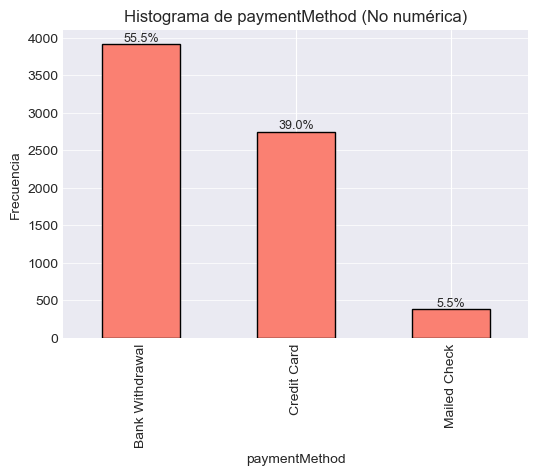

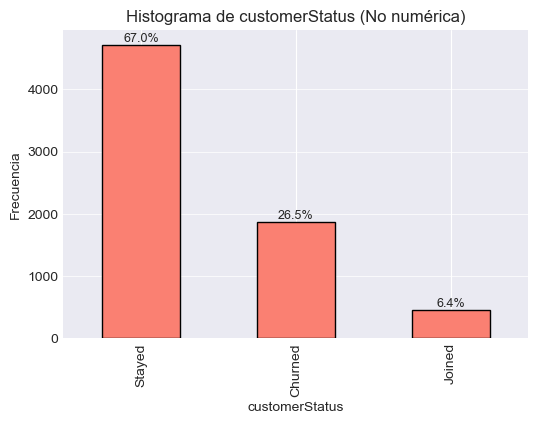

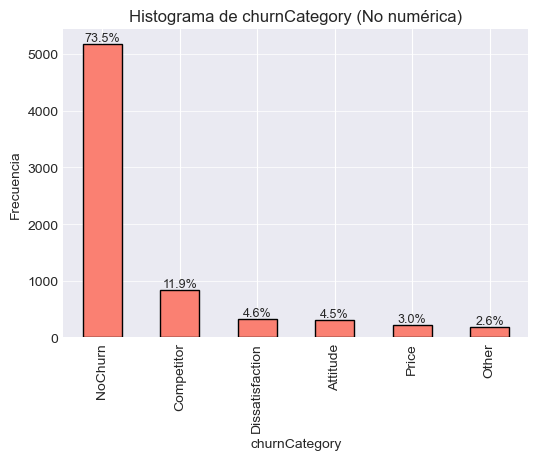

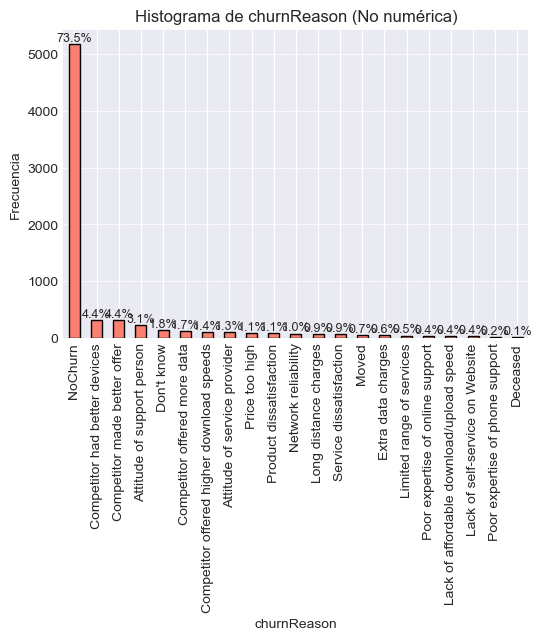

In [117]:
##revisar los datos de las columnas numericas y no numericas

for col in columnas_numericas:
    datos = df_test_copy[col].dropna()
    if len(datos) > 1:
        plt.figure(figsize=(6, 4))
        plt.hist(datos, bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Histograma de {col} (Numérica)')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

# Histograma para características no numéricas (usando conteo de frecuencias y mostrando porcentaje)
for col in columnas_no_numericas:
    datos = df_test_copy[col].dropna()
    if len(datos) > 1:
        conteos = datos.value_counts()
        porcentajes = conteos / conteos.sum() * 100
        plt.figure(figsize=(6, 4))
        ax = conteos.plot(kind='bar', color='salmon', edgecolor='black')
        plt.title(f'Histograma de {col} (No numérica)')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.grid(axis='y', alpha=0.75)
        # Agregar porcentaje encima de cada barra
        for i, (idx, valor) in enumerate(conteos.items()):
            porcentaje = porcentajes[idx]
            ax.text(i, valor, f'{porcentaje:.1f}%', ha='center', va='bottom', fontsize=9, rotation=0)
        plt.show()


In [120]:
# Análisis de correlación
# Calculamos la matriz de correlación para las columnas numéricas
correlation_matrix = df_test_copy[columnas_numericas].corr().abs()

# Seleccionamos solo la parte superior de la matriz (sin la diagonal)
correlation_pairs = (
    correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    .stack()
    .reset_index()
)
correlation_pairs.columns = ['Variable_1', 'Variable_2', 'Correlacion']

# Filtramos las combinaciones con correlación mayor a 0.20
correlation_pairs_filtradas = correlation_pairs[correlation_pairs['Correlacion'] > 0.20]

# Ordenamos de mayor a menor correlación
correlation_pairs_filtradas = correlation_pairs_filtradas.sort_values(by='Correlacion', ascending=False).reset_index(drop=True)

print("Combinaciones de variables numéricas con correlación mayor a 0.20:")
display(correlation_pairs_filtradas)


Combinaciones de variables numéricas con correlación mayor a 0.20:


,Variable_1,Variable_2,Correlacion
0,totalCharges,totalRevenue,0.972212
1,tenureInMonths,totalRevenue,0.853146
2,tenureInMonths,totalCharges,0.826074
3,totalLongDistanceCharges,totalRevenue,0.778559
4,tenureInMonths,totalLongDistanceCharges,0.674149
5,monthlyCharge,totalCharges,0.622810
6,totalCharges,totalLongDistanceCharges,0.610185
7,avgMonthlyLongDistanceCharges,totalLongDistanceCharges,0.599828
8,monthlyCharge,totalRevenue,0.563249
9,age,avgMonthlyGbDownload,0.376595


In [121]:
# Medir la correlación entre variables no numéricas usando Cramér's V

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] == 1 or confusion_matrix.shape[1] == 1:
        return np.nan  # No se puede calcular Cramér's V con una sola categoría
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Corrección de bias para tablas no cuadradas
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Crear matriz de correlación para variables no numéricas
cat_cols = columnas_no_numericas
cramers_results = []

for col1, col2 in itertools.combinations(cat_cols, 2):
    v = cramers_v(df_test_copy[col1], df_test_copy[col2])
    cramers_results.append({
        'Variable_1': col1,
        'Variable_2': col2,
        "Cramers_V": v
    })

df_cramers = pd.DataFrame(cramers_results)
df_cramers_filtrada = df_cramers[df_cramers['Cramers_V'] > 0.80].sort_values(by='Cramers_V', ascending=False).reset_index(drop=True)

print("Combinaciones de variables no numéricas con Cramér's V mayor a 0.20:")
pd.set_option('display.max_rows', None)
display(df_cramers.sort_values(by='Cramers_V', ascending=False).reset_index(drop=True))


Combinaciones de variables no numéricas con Cramér's V mayor a 0.20:


,Variable_1,Variable_2,Cramers_V
0,internetService,streamingTv,0.999929
1,internetService,premiumTechSupport,0.999929
2,internetService,streamingMovies,0.999929
3,internetService,unlimitedData,0.999929
4,internetService,deviceProtectionPlan,0.999929
5,internetService,onlineBackup,0.999929
6,internetService,streamingMusic,0.999929
7,internetService,onlineSecurity,0.999929
8,phoneService,multipleLines,0.999929
9,internetService,internetType,0.999858


In [130]:
variables_a_eliminar = [
   # Grupo 1: Servicios de Internet Redundantes (correlacionados con internetService)
   'streamingTv',
   'premiumTechSupport', 
   'streamingMovies',
   'unlimitedData',
   'deviceProtectionPlan',
   'onlineBackup',
   'streamingMusic',
   'onlineSecurity',
   'avgMonthlyGbDownload',
   'avgMonthlyLongDistanceCharges',
   
   # Grupo 2: Variables de Teléfono Redundantes
   'multipleLines',  # correlacionado con phoneService
   
   # Grupo 3: Variables de Churn Redundantes  
   'churnReason',
   'churnCategory'     # correlacionado con churnCategory
]

In [124]:
df_test_copy.columns

Index(['gender', 'age', 'married', 'numberOfDependents', 'numberOfReferrals',
       'tenureInMonths', 'offer', 'phoneService',
       'avgMonthlyLongDistanceCharges', 'multipleLines', 'internetService',
       'internetType', 'avgMonthlyGbDownload', 'onlineSecurity',
       'onlineBackup', 'deviceProtectionPlan', 'premiumTechSupport',
       'streamingTv', 'streamingMovies', 'streamingMusic', 'unlimitedData',
       'contract', 'paperlessBilling', 'paymentMethod', 'monthlyCharge',
       'totalCharges', 'totalRefunds', 'totalExtraDataCharges',
       'totalLongDistanceCharges', 'totalRevenue', 'customerStatus',
       'churnCategory', 'churnReason'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, kruskal
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

def cramers_v_simple(x, y):
    """
    Calcula Cramér's V entre dos variables categóricas - versión simplificada
    """
    try:
        # Crear tabla de contingencia
        crosstab = pd.crosstab(x, y)
        
        # Calcular chi-cuadrado
        chi2, p, dof, expected = chi2_contingency(crosstab)
        
        # Calcular Cramér's V
        n = crosstab.sum().sum()
        cramer = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
        
        return cramer
    except:
        return 0

def eta_squared_simple(numeric_var, categorical_var):
    """
    Calcula Eta-squared usando test de Kruskal-Wallis - versión simplificada
    """
    try:
        # Crear DataFrame temporal
        df_temp = pd.DataFrame({'num': numeric_var, 'cat': categorical_var}).dropna()
        
        if len(df_temp) < 10:
            return 0
            
        # Agrupar por categoría
        groups = [group['num'].values for name, group in df_temp.groupby('cat')]
        
        if len(groups) <= 1:
            return 0
            
        # Test de Kruskal-Wallis
        h_stat, p_value = kruskal(*groups)
        
        # Calcular eta-squared aproximado
        n = len(df_temp)
        k = len(groups)
        eta_squared = (h_stat - k + 1) / (n - k)
        
        return max(0, min(1, eta_squared))
    except:
        return 0

def mutual_info_simple(variable, target, is_numeric=True):
    """
    Calcula Información Mutua Normalizada - versión simplificada
    """
    try:
        from scipy.stats import entropy
        
        # Crear DataFrame temporal sin NaN
        if is_numeric:
            df_temp = pd.DataFrame({'var': variable, 'target': target}).dropna()
        else:
            df_temp = pd.DataFrame({'var': variable.astype(str), 'target': target.astype(str)}).dropna()
        
        if len(df_temp) < 10:
            return 0
        
        # Codificar target
        le_target = LabelEncoder()
        y_encoded = le_target.fit_transform(df_temp['target'])
        
        if is_numeric:
            # Para numéricas: usar la variable directamente
            X = df_temp['var'].values.reshape(-1, 1)
        else:
            # Para categóricas: codificar
            le_var = LabelEncoder()
            X = le_var.fit_transform(df_temp['var']).reshape(-1, 1)
        
        # Calcular MI
        mi = mutual_info_classif(X, y_encoded, random_state=42)[0]
        
        # Normalizar por entropía del target
        _, counts_y = np.unique(y_encoded, return_counts=True)
        entropy_y = entropy(counts_y / len(y_encoded), base=2)
        
        if entropy_y > 0:
            return mi / entropy_y
        else:
            return 0
            
    except Exception as e:
        print(f"    Error en MI: {e}")
        return 0

def crear_bins_seguros(data, n_bins=4):
    """
    Crea bins de forma segura para variables numéricas
    """
    try:
        # Remover NaN
        clean_data = data.dropna()
        
        if len(clean_data) == 0:
            return None
            
        # Obtener valores únicos
        unique_vals = clean_data.unique()
        
        if len(unique_vals) <= 2:
            # Si hay muy pocos valores únicos, usar como categórica
            return clean_data.astype(str)
        elif len(unique_vals) <= n_bins:
            # Si hay pocos valores únicos, usar cada uno como bin
            return clean_data.astype(str)
        else:
            # Crear bins por percentiles
            try:
                # Intentar percentiles uniformes
                percentiles = np.linspace(0, 100, n_bins + 1)
                bin_edges = np.percentile(clean_data, percentiles)
                
                # Asegurar que los edges sean únicos
                bin_edges = np.unique(bin_edges)
                
                if len(bin_edges) >= 2:
                    return pd.cut(clean_data, bins=bin_edges, duplicates='drop', include_lowest=True)
                else:
                    return clean_data.astype(str)
            except:
                # Si todo falla, convertir a string
                return clean_data.astype(str)
                
    except:
        return None



In [165]:

# Identificar variables a analizar
excluir = ['customerid', 'customerStatus','churnReason','churnCategory']
todas_columnas = [col for col in df_test_copy.columns if col not in excluir]

# Separar por tipo
numericas = [col for col in todas_columnas 
                 if df_test_copy[col].dtype in ['int64', 'float64', 'int32', 'float32']]
    
categoricas = [col for col in todas_columnas 
                   if col not in numericas]
    
print(f"\n📊 Variables a analizar:")
print(f"   Numéricas: {len(numericas)}")
print(f"   Categóricas: {len(categoricas)}")
display(todas_columnas)



📊 Variables a analizar:
   Numéricas: 12
   Categóricas: 18


['gender',
 'age',
 'married',
 'numberOfDependents',
 'numberOfReferrals',
 'tenureInMonths',
 'offer',
 'phoneService',
 'avgMonthlyLongDistanceCharges',
 'multipleLines',
 'internetService',
 'internetType',
 'avgMonthlyGbDownload',
 'onlineSecurity',
 'onlineBackup',
 'deviceProtectionPlan',
 'premiumTechSupport',
 'streamingTv',
 'streamingMovies',
 'streamingMusic',
 'unlimitedData',
 'contract',
 'paperlessBilling',
 'paymentMethod',
 'monthlyCharge',
 'totalCharges',
 'totalRefunds',
 'totalExtraDataCharges',
 'totalLongDistanceCharges',
 'totalRevenue']

In [169]:
# Lista de resultados
resultados = []

for col in numericas:
    try:
        # Obtener datos limpios
        mask = df_test_copy[col].notna() & df_test_copy['customerStatus'].notna()
        data_num = df_test_copy.loc[mask, col]
        data_target = df_test_copy.loc[mask, 'customerStatus']
        
        # Calcular métricas
        #print(f"Total de datos: {len(df_test_copy)}")
        #print(f"Datos válidos: {len(data_num)}")
        
        # 1. Cramér's V (requiere discretización)
        bins_data = crear_bins_seguros(data_num)
        if bins_data is not None:
            cramers = cramers_v_simple(bins_data, data_target)
        else:
            cramers = 0
        
        # 2. Eta-squared
        eta_sq = eta_squared_simple(data_num, data_target)
        
        # 3. MI Normalizada
        mi_norm = mutual_info_simple(data_num, data_target, is_numeric=True)
        
        # Guardar resultado
        resultados.append({
            'Variable': col,
            'Tipo': 'Numérica',
            'Cramers_V': round(cramers, 6),
            'Eta_Squared_Kruskal': round(eta_sq, 6),
            'MI_Normalizada': round(mi_norm, 6)
        })         
    except Exception as e:
        print(f"   ❌ Error: {str(e)[:50]}...")
        resultados.append({
            'Variable': col,
            'Tipo': 'Numérica',
            'Cramers_V': 0,
            'Eta_Squared_Kruskal': 0,
            'MI_Normalizada': 0
        })

# Procesar VARIABLES CATEGÓRICAS 

for col in categoricas:
    try:
        # Obtener datos limpios
        mask = df_test_copy[col].notna() & df_test_copy['customerStatus'].notna()
        data_cat = df_test_copy.loc[mask, col]
        data_target = df_test_copy.loc[mask, 'customerStatus']
        
        if len(data_cat) < 10:
            print(f" Pocos datos válidos ({len(data_cat)})")
            continue
        
        #print(f"  Datos válidos: {len(data_cat)}")
        #print(f"  Categorías únicas: {data_cat.nunique()}")
        
        # Calcular métricas
        # 1. Cramér's V
        cramers = cramers_v_simple(data_cat, data_target)
        
        # 2. Eta-squared (No aplica para cat vs cat)
        eta_sq = 0
        
        # 3. MI Normalizada
        mi_norm = mutual_info_simple(data_cat, data_target, is_numeric=False)
        
        # Guardar resultado
        resultados.append({
            'Variable': col,
            'Tipo': 'Categórica',
            'Cramers_V': round(cramers, 6),
            'Eta_Squared_Kruskal': round(eta_sq, 6),
            'MI_Normalizada': round(mi_norm, 6)
        })       
    except Exception as e:
        print(f"   ❌ Error: {str(e)[:50]}...")
        resultados.append({
            'Variable': col,
            'Tipo': 'Categórica',
            'Cramers_V': 0,
            'Eta_Squared_Kruskal': 0,
            'MI_Normalizada': 0
        })

# RESULTADOS FINALES

df_correlaciones = pd.DataFrame(resultados)
df_correlaciones = df_correlaciones.sort_values('MI_Normalizada', ascending=False)
df_correlaciones = df_correlaciones.reset_index(drop=True)

print(f"\n{'='*80}")
print("🎯 CORRELACIONES CON customerStatus (ordenado por MI Normalizada)")
print(f"{'='*80}")
print(df_correlaciones.to_string(index=False))
    



🎯 CORRELACIONES CON customerStatus (ordenado por MI Normalizada)
                     Variable       Tipo  Cramers_V  Eta_Squared_Kruskal  MI_Normalizada
               tenureInMonths   Numérica   0.433111             0.334386        0.253746
                 totalRevenue   Numérica   0.401611             0.257076        0.186753
                 totalCharges   Numérica   0.388763             0.238338        0.185372
     totalLongDistanceCharges   Numérica   0.331482             0.170598        0.152507
                     contract Categórica   0.375617             0.000000        0.134762
            numberOfReferrals   Numérica   0.311806             0.082667        0.081701
                        offer Categórica   0.282891             0.000000        0.074671
               onlineSecurity Categórica   0.265337             0.000000        0.070076
           premiumTechSupport Categórica   0.262224             0.000000        0.065220
                monthlyCharge   Numérica   0

In [185]:
print(df_test_copy['streamingTv'].value_counts())
print(df_test_copy['streamingMovies'].value_counts())
print(df_test_copy['streamingMusic'].value_counts())
print(df_test_copy['unlimitedData'].value_counts())
print(df_test_copy['onlineSecurity'].value_counts())
print(df_test_copy['onlineBackup'].value_counts())
print(df_test_copy['deviceProtectionPlan'].value_counts())
print(df_test_copy['premiumTechSupport'].value_counts())

streamingTv
No                   2810
Yes                  2707
NoInternetService    1526
Name: count, dtype: int64
streamingMovies
No                   2785
Yes                  2732
NoInternetService    1526
Name: count, dtype: int64
streamingMusic
No                   3029
Yes                  2488
NoInternetService    1526
Name: count, dtype: int64
unlimitedData
Yes                  4745
NoInternetService    1526
No                    772
Name: count, dtype: int64
onlineSecurity
No                   3498
Yes                  2019
NoInternetService    1526
Name: count, dtype: int64
onlineBackup
No                   3088
Yes                  2429
NoInternetService    1526
Name: count, dtype: int64
deviceProtectionPlan
No                   3095
Yes                  2422
NoInternetService    1526
Name: count, dtype: int64
premiumTechSupport
No                   3473
Yes                  2044
NoInternetService    1526
Name: count, dtype: int64


In [186]:
# Contar servicios de entretenimiento
df_test_copy['entertainment_services_count'] = (
    df_test_copy['streamingTv'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['streamingMovies'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['streamingMusic'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['unlimitedData'].map({'Yes': 1}).fillna(0).astype(int)
)

# Contar servicios de protección
df_test_copy['protection_services_count'] = (
    df_test_copy['onlineSecurity'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['onlineBackup'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['deviceProtectionPlan'].map({'Yes': 1}).fillna(0).astype(int) +
    df_test_copy['premiumTechSupport'].map({'Yes': 1}).fillna(0).astype(int)
)

# Total de servicios adicionales
df_test_copy['total_addon_services'] = df_test_copy['entertainment_services_count'] + df_test_copy['protection_services_count']

# Perfil de consumidor
def consumer_profile(row):
    ent = row['entertainment_services_count']
    prot = row['protection_services_count']
    
    if ent >= 3 and prot >= 2: return 'Premium_All'
    elif ent >= 2: return 'Entertainment_Heavy'
    elif prot >= 2: return 'Security_Conscious'
    elif ent >= 1 or prot >= 1: return 'Moderate_User'
    else: return 'Basic_Only'

df_test_copy['consumer_profile'] = df_test_copy.apply(consumer_profile, axis=1)

# Propensión al exceso de uso
df_test_copy['data_overage_propensity'] = df_test_copy['totalExtraDataCharges'] / np.maximum(df_test_copy['totalCharges'], 1)
df_test_copy['longdist_usage_propensity'] = df_test_copy['totalLongDistanceCharges'] / np.maximum(df_test_copy['totalCharges'], 1)

# Indicador de usuario intensivo
df_test_copy['heavy_user'] = np.where(
    (df_test_copy['totalExtraDataCharges'] > 0) | (df_test_copy['avgMonthlyGbDownload'] > df_test_copy['avgMonthlyGbDownload'].quantile(0.75)),
    'Heavy', 'Normal'
)

# Ratio de servicios vs tenure (adopción temprana vs tardía)
df_test_copy['service_adoption_rate'] = df_test_copy['total_addon_services'] / np.maximum(df_test_copy  ['tenureInMonths'], 1)

df_test_copy['base_revenue'] = df_test_copy['totalCharges'] - df_test_copy['totalExtraDataCharges'] - df_test_copy['totalLongDistanceCharges']
df_test_copy['usage_revenue'] = df_test_copy['totalExtraDataCharges'] + df_test_copy['totalLongDistanceCharges']
df_test_copy['usage_revenue_ratio'] = df_test_copy['usage_revenue'] / np.maximum(df_test_copy['totalRevenue'], 1)

def profitability_tier(revenue_value, revenue_series):
    if revenue_value > revenue_series.quantile(0.8): 
        return 'High_Value'
    elif revenue_value > revenue_series.quantile(0.6): 
        return 'Medium_High'
    elif revenue_value > revenue_series.quantile(0.4): 
        return 'Medium'
    elif revenue_value > revenue_series.quantile(0.2): 
        return 'Medium_Low'
    else: 
        return 'Low_Value'

df_test_copy['value_tier'] = df_test_copy['totalRevenue'].apply(
    lambda x: profitability_tier(x, df_test_copy['totalRevenue'])
)

modelo_final_corregido = [
    # Core business metrics
    'tenureInMonths',
    'totalRevenue',
    'contract',
    
    # Service adoption pattern
    'consumer_profile',          # En lugar de servicios individuales
    'entertainment_services_count',
    'protection_services_count',
    
    # Usage behavior  
    'data_overage_propensity',
    'heavy_user',
    'multipleLines',            # Sí es independiente
    
    # Social & promotional
    'numberOfReferrals',
    'offer',
]

In [189]:
todas_columnas_X = modelo_final_corregido
df_test_copy['customerStatus_bin'] = df_test_copy['customerStatus'].map(lambda x: 0 if x == 'Churned' else 1)
print("Cantidad de valores NA por columna en df_test_copy:")
print(df_test_copy.isna().sum())
df_test_copy.customerStatus.value_counts()



Cantidad de valores NA por columna en df_test_copy:
gender                           0
age                              0
married                          0
numberOfDependents               0
numberOfReferrals                0
tenureInMonths                   0
offer                            0
phoneService                     0
avgMonthlyLongDistanceCharges    0
multipleLines                    0
internetService                  0
internetType                     0
avgMonthlyGbDownload             0
onlineSecurity                   0
onlineBackup                     0
deviceProtectionPlan             0
premiumTechSupport               0
streamingTv                      0
streamingMovies                  0
streamingMusic                   0
unlimitedData                    0
contract                         0
paperlessBilling                 0
paymentMethod                    0
monthlyCharge                    0
totalCharges                     0
totalRefunds                     0
tot

customerStatus
Stayed     4720
Churned    1869
Joined      454
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = df_test_copy[todas_columnas_X]
y = df_test_copy['customerStatus_bin']

# Identificar columnas categóricas en X
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Aplicar LabelEncoder a cada columna categórica
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le  # Guardar el encoder por si se necesita después

# 8. División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
print("Clases únicas en y_test:", np.unique(y_test))
print("Clases únicas en y_pred:", np.unique(y_pred))
print(y_test.value_counts())
print("Todas las clases del encoder:", le.classes_)

Clases únicas en y_test: [0 1]
Clases únicas en y_pred: [0 1]
Todas las clases del encoder: ['NoOfferAccepted' 'Offer A' 'Offer B' 'Offer C' 'Offer D' 'Offer E']


In [200]:


###pimer modelo entrenado
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # o 'multi:softprob' si son más de 2 clases
    random_state=42,
    n_estimators=100,           # Empezar con pocos árboles
    max_depth=6,               # Profundidad moderada
    learning_rate=0.1,         # Learning rate estándar
    subsample=0.8,             # Submuestreo para evitar overfitting
    colsample_bytree=0.8,      # Submuestreo de features
    scale_pos_weight=1,        # Ajustaremos si hay desbalance
    eval_metric='logloss'      # Métrica de evaluación
)

# 3.2 Entrenar modelo
xgb_model.fit(X_train, y_train)

# 3.3 Predicciones
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)

print("Modelo básico entrenado")

# 4.1 F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' para multiclase
print(f"F1 Score: {f1:.4f}")

# 4.2 Reporte completo
print("\nReporte de clasificación:")
target_names = ['Se fue', 'Se quedo']  

print(classification_report(y_test, y_pred, target_names=target_names))

# 4.3 Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# 4.4 F1 por clase (si es multiclase)
f1_per_class = f1_score(y_test, y_pred, average=None)
for i, clase in enumerate(target_names):
    print(f"F1 {clase}: {f1_per_class[i]:.4f}")




Modelo básico entrenado
F1 Score: 0.8267

Reporte de clasificación:
              precision    recall  f1-score   support

      Se fue       0.69      0.64      0.66       374
    Se quedo       0.87      0.90      0.89      1035

    accuracy                           0.83      1409
   macro avg       0.78      0.77      0.77      1409
weighted avg       0.83      0.83      0.83      1409


Matriz de confusión:
[[239 135]
 [106 929]]
F1 Se fue: 0.6648
F1 Se quedo: 0.8852


In [201]:
class_counts = np.bincount(y_train)
if len(class_counts) == 2:  # Clasificación binaria
    ratio = class_counts[0] / class_counts[1]
    print(f"Ratio de desbalance: {ratio:.2f}")
    
    # 5.2 Ajustar scale_pos_weight
    xgb_balanced = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=ratio,  # Ajuste para desbalance
        eval_metric='logloss'
    )
    
    xgb_balanced.fit(X_train, y_train)
    y_pred_balanced = xgb_balanced.predict(X_test)
    f1_balanced = f1_score(y_test, y_pred_balanced, average='weighted')
    
    print(f"F1 con ajuste de balance: {f1_balanced:.4f}")

Ratio de desbalance: 0.36
F1 con ajuste de balance: 0.8157


In [202]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# 6.2 Configurar GridSearch con F1 como métrica
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        scale_pos_weight=ratio if 'ratio' in locals() else 1
    ),
    param_grid=param_grid,
    scoring='f1_weighted',  # Optimizar para F1
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1,             # Usar todos los cores
    verbose=1
)

print("Iniciando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor F1 CV: {grid_search.best_score_:.4f}")

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Mejores parámetros: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Mejor F1 CV: 0.8014


In [205]:
# 7.2 Predicciones finales
best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)
y_pred_proba_final = best_model.predict_proba(X_test)

# 7.3 Evaluación final
f1_final = f1_score(y_test, y_pred_final, average='weighted')
print(f"\nF1 Score final: {f1_final:.4f}")

print("\nReporte final:")
print(classification_report(y_test, y_pred_final, target_names=target_names))


F1 Score final: 0.8098

Reporte final:
              precision    recall  f1-score   support

      Se fue       0.60      0.78      0.68       374
    Se quedo       0.91      0.81      0.86      1035

    accuracy                           0.80      1409
   macro avg       0.75      0.79      0.77      1409
weighted avg       0.83      0.80      0.81      1409



In [206]:
# 8.1 Cross-validation para validar estabilidad del F1
cv_f1_scores = cross_val_score(
    best_model, X_train, y_train, 
    cv=5, scoring='f1_weighted'
)

print(f"\nF1 Scores CV: {cv_f1_scores}")
print(f"F1 promedio CV: {cv_f1_scores.mean():.4f} (+/- {cv_f1_scores.std() * 2:.4f})")


F1 Scores CV: [0.80817213 0.80052815 0.79591898 0.78613243 0.8086675 ]
F1 promedio CV: 0.7999 (+/- 0.0168)



Top 10 features más importantes:
                        feature  importance
2                      contract    0.546168
9             numberOfReferrals    0.116975
4  entertainment_services_count    0.054781
3              consumer_profile    0.041363
0                tenureInMonths    0.038125
8                 multipleLines    0.036519
5     protection_services_count    0.036172
6       data_overage_propensity    0.035238
1                  totalRevenue    0.033044
7                    heavy_user    0.032894


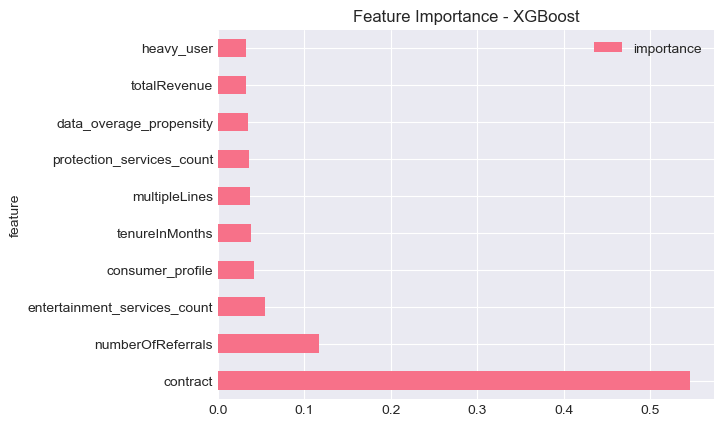

In [207]:
# 9.1 Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 features más importantes:")
print(feature_importance.head(10))

# 9.2 Plot de importancia (opcional)

feature_importance.head(10).plot(x='feature', y='importance', kind='barh')
plt.title('Feature Importance - XGBoost')
plt.show()

In [199]:


df_test_copy[['customerStatus_bin','customerStatus']]

,customerStatus_bin,customerStatus
0,1,Stayed
1,1,Stayed
2,0,Churned
3,0,Churned
4,0,Churned
5,1,Stayed
6,1,Stayed
7,1,Stayed
8,1,Stayed
9,1,Stayed


In [170]:
##outalier en datos categori
def detect_rare_categories(df, column, threshold=0.05):
    """
    Detecta categorías que aparecen menos del threshold% de las veces
    """
    value_counts = df[column].value_counts(normalize=True)
    rare_categories = value_counts[value_counts < threshold].index.tolist()
    
    for cat in rare_categories:
        count = df[column].value_counts()[cat]
        pct = value_counts[cat] * 100
    
    return rare_categories

# Aplicar la función detect_rare_categories a las columnas no numéricas en df
rare_cats_results = []

for col in columnas_no_numericas:
    rare_categories = detect_rare_categories(df_test_copy, col)
    for cat in rare_categories:
        count = df_test_copy[col].value_counts()[cat] ## cuenta cuantas veces aparece la categoria en la columna
        pct = df_test_copy[col].value_counts(normalize=True)[cat] * 100 ## porcentaje de veces que aparece la categoria en la columna
        rare_cats_results.append({
            'columna': col,
            'categoria': cat,
            'conteo': count,
            'porcentaje': pct
        })

df_rare_cats = pd.DataFrame(rare_cats_results)
print("Resumen de categorías raras encontradas en columnas no numéricas:")
df_rare_cats


Resumen de categorías raras encontradas en columnas no numéricas:


,columna,categoria,conteo,porcentaje
0,churnCategory,Dissatisfaction,321,4.557717
1,churnCategory,Attitude,314,4.458327
2,churnCategory,Price,211,2.995882
3,churnCategory,Other,182,2.584126
4,churnReason,Competitor had better devices,313,4.444129
5,churnReason,Competitor made better offer,311,4.415732
6,churnReason,Attitude of support person,220,3.123669
7,churnReason,Don't know,130,1.845804
8,churnReason,Competitor offered more data,117,1.661224
9,churnReason,Competitor offered higher download speeds,100,1.419849


In [ ]:
## convierte las categorias con menos del 1% de ocurrencias en la columna en 'Others'
def group_rare_categories(df, column, threshold=0.01):
    rare_cats = detect_rare_categories(df, column, threshold)
    df[column] = df[column].replace(rare_cats, 'Others')
    return df

# Aplicar la función group_rare_categories a todas las columnas no numéricas en df_test_copy
df_test_copy_grouped = df_test_copy.copy()
for col in columnas_no_numericas:
    df_test_copy_grouped = group_rare_categories(df_test_copy_grouped, col, threshold=0.01)



In [52]:
df_test_copy_grouped.columns
df_test_copy_grouped.churnReason.value_counts()


churnReason
NoChurn                                      5174
Others                                        357
Competitor had better devices                 313
Competitor made better offer                  311
Attitude of support person                    220
Don't know                                    130
Competitor offered more data                  117
Competitor offered higher download speeds     100
Attitude of service provider                   94
Price too high                                 78
Product dissatisfaction                        77
Network reliability                            72
Name: count, dtype: int64

In [37]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

print("🔄 PROPUESTA 1: Balanceo de Clases")
print("="*50)

# SMOTE para generar muestras sintéticas de la clase minoritaria
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_final, y_train)

print(f"   • Distribución original: {y_train.value_counts().to_dict()}")
print(f"   • Distribución balanceada: {pd.Series(y_train_balanced).value_counts().to_dict()}")
print(f"   • Nuevas dimensiones: X={X_train_balanced.shape}, y={len(y_train_balanced)}")

# Entrenar modelo con datos balanceados
rf_balanced = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_balanced.fit(X_train_balanced, y_train_balanced)

# Evaluar
y_pred_balanced = rf_balanced.predict(X_test_final)
print(f"   • F1-Score con balanceo: {f1_score(y_test, y_pred_balanced):.4f}")

🔄 PROPUESTA 1: Balanceo de Clases
   • Distribución original: {0: 3776, 1: 1495}
   • Distribución balanceada: {0: 3776, 1: 3776}
   • Nuevas dimensiones: X=(7552, 25), y=7552
   • F1-Score con balanceo: 0.7336


In [38]:
from sklearn.model_selection import GridSearchCV

print("\n⚙️ PROPUESTA 2: Optimización de Hiperparámetros")
print("="*50)

# Grid Search para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("   • Optimizando Random Forest...")
grid_search_rf.fit(X_train_final, y_train)

print(f"   • Mejores parámetros: {grid_search_rf.best_params_}")
print(f"   • Mejor F1-Score: {grid_search_rf.best_score_:.4f}")

# Evaluar modelo optimizado
mejor_rf = grid_search_rf.best_estimator_
y_pred_optimizado = mejor_rf.predict(X_test_final)
print(f"   • F1-Score en test: {f1_score(y_test, y_pred_optimizado):.4f}")


⚙️ PROPUESTA 2: Optimización de Hiperparámetros
   • Optimizando Random Forest...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
   • Mejores parámetros: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
   • Mejor F1-Score: 0.7799
   • F1-Score en test: 0.7350


In [39]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

print("\n🎭 PROPUESTA 3: Ensemble Methods")
print("="*50)

# Voting Classifier (Hard Voting)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42))
]

voting_hard = VotingClassifier(estimators=estimators, voting='hard')
voting_soft = VotingClassifier(estimators=estimators, voting='soft')

print("   • Entrenando Voting Classifier (Hard)...")
voting_hard.fit(X_train_final, y_train)
y_pred_hard = voting_hard.predict(X_test_final)

print("   • Entrenando Voting Classifier (Soft)...")
voting_soft.fit(X_train_final, y_train)
y_pred_soft = voting_soft.predict(X_test_final)

print(f"   • F1-Score Hard Voting: {f1_score(y_test, y_pred_hard):.4f}")
print(f"   • F1-Score Soft Voting: {f1_score(y_test, y_pred_soft):.4f}")


🎭 PROPUESTA 3: Ensemble Methods
   • Entrenando Voting Classifier (Hard)...
   • Entrenando Voting Classifier (Soft)...
   • F1-Score Hard Voting: 0.7273
   • F1-Score Soft Voting: 0.7284


In [40]:
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.preprocessing import PolynomialFeatures

print("\n📊 PROPUESTA 4: Feature Engineering Avanzado")
print("="*50)

# Selección basada en importancia de características
selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold='median'
)

X_train_selected = selector.fit_transform(X_train_final, y_train)
X_test_selected = selector.transform(X_test_final)

selected_features = X_train_final.columns[selector.get_support()].tolist()
print(f"   • Características seleccionadas: {len(selected_features)} de {X_train_final.shape[1]}")

# Entrenar modelo con características seleccionadas
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

y_pred_selected = rf_selected.predict(X_test_selected)
print(f"   • F1-Score con selección: {f1_score(y_test, y_pred_selected):.4f}")

# RFE con validación cruzada
rfe_cv = RFECV(
    estimator=RandomForestClassifier(n_estimators=50, random_state=42),
    step=1,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print("   • Ejecutando RFE con CV...")
rfe_cv.fit(X_train_final, y_train)

X_train_rfe = rfe_cv.transform(X_train_final)
X_test_rfe = rfe_cv.transform(X_test_final)

print(f"   • Características RFE: {X_train_rfe.shape[1]}")

rf_rfe = RandomForestClassifier(n_estimators=100, random_state=42)
rf_rfe.fit(X_train_rfe, y_train)

y_pred_rfe = rf_rfe.predict(X_test_rfe)
print(f"   • F1-Score con RFE: {f1_score(y_test, y_pred_rfe):.4f}")


📊 PROPUESTA 4: Feature Engineering Avanzado
   • Características seleccionadas: 13 de 25
   • F1-Score con selección: 0.7207
   • Ejecutando RFE con CV...
   • Características RFE: 20
   • F1-Score con RFE: 0.6985


In [41]:
from sklearn.metrics import precision_recall_curve, roc_curve
import numpy as np

print("\n�� PROPUESTA 5: Optimización de Umbrales y Métricas de Negocio")
print("="*50)

# Usar el mejor modelo (Random Forest optimizado)
mejor_modelo = grid_search_rf.best_estimator_
y_pred_proba = mejor_modelo.predict_proba(X_test_final)[:, 1]

# Encontrar el mejor umbral para F1-Score
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_threshold_idx = np.argmax(f1_scores[:-1])  # Excluir el último valor
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"   • Mejor umbral para F1-Score: {best_threshold:.4f}")
print(f"   • F1-Score con umbral optimizado: {best_f1:.4f}")

# Aplicar umbral optimizado
y_pred_optimizado_threshold = (y_pred_proba >= best_threshold).astype(int)

# Métricas con umbral optimizado
accuracy_opt = accuracy_score(y_test, y_pred_optimizado_threshold)
precision_opt = precision_score(y_test, y_pred_optimizado_threshold)
recall_opt = recall_score(y_test, y_pred_optimizado_threshold)
f1_opt = f1_score(y_test, y_pred_optimizado_threshold)

print(f"   • Métricas con umbral optimizado:")
print(f"     - Accuracy: {accuracy_opt:.4f}")
print(f"     - Precision: {precision_opt:.4f}")
print(f"     - Recall: {recall_opt:.4f}")
print(f"     - F1-Score: {f1_opt:.4f}")

# Análisis de costo-beneficio (ejemplo)
print(f"\n   • Análisis de Negocio:")
print(f"     - Clientes identificados como churn: {y_pred_optimizado_threshold.sum()}")
print(f"     - Tasa de detección: {recall_opt:.2%}")
print(f"     - Precisión de detección: {precision_opt:.2%}")


�� PROPUESTA 5: Optimización de Umbrales y Métricas de Negocio
   • Mejor umbral para F1-Score: 0.5381
   • F1-Score con umbral optimizado: 0.7410
   • Métricas con umbral optimizado:
     - Accuracy: 0.8520
     - Precision: 0.7361
     - Recall: 0.7460
     - F1-Score: 0.7410

   • Análisis de Negocio:
     - Clientes identificados como churn: 379
     - Tasa de detección: 74.60%
     - Precisión de detección: 73.61%
